# Random Forest Classifier for Audio Tagging

This notebook trains a Random Forest classifier on tabular audio features for single-class audio samples.

## Workflow:
1. Load tabular features and labels
2. Filter to single-class samples only
3. Split into train/validation/test sets (10% test holdout)
4. Train Random Forest using fastai
5. Evaluate on test set

In [38]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# fastai imports for tabular data
from fastai.tabular.all import *

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

## 1. Load Data

In [39]:
# Define paths
DATA_PATH = Path('./work')
FEATURES_CSV = DATA_PATH / 'trn_curated_feature.csv'
LABELS_CSV = Path('./input/train_curated.csv')

# Load features
print("Loading features...")
features_df = pd.read_csv(FEATURES_CSV)
print(f"Features shape: {features_df.shape}")
print(f"Feature columns: {len(features_df.columns)}")

# Load labels
print("\nLoading labels...")
labels_df = pd.read_csv(LABELS_CSV)
print(f"Labels shape: {labels_df.shape}")
print(labels_df.head())

Loading features...


Features shape: (4970, 2475)
Feature columns: 2475

Loading labels...
Labels shape: (4970, 2)
          fname           labels
0  0006ae4e.wav             Bark
1  0019ef41.wav         Raindrop
2  001ec0ad.wav  Finger_snapping
3  0026c7cb.wav              Run
4  0026f116.wav  Finger_snapping


In [40]:
# Merge features and labels
# The features CSV has 'file' column, labels CSV has 'fname' column
df = features_df.merge(labels_df, left_on='file', right_on='fname', how='inner')
print(f"Merged dataframe shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()

Merged dataframe shape: (4970, 2477)

First few rows:


,file,stft_mean_0,stft_mean_1,stft_mean_2,stft_mean_3,stft_mean_4,stft_mean_5,stft_mean_6,stft_mean_7,stft_mean_8,...,cqt_std_76,cqt_std_77,cqt_std_78,cqt_std_79,cqt_std_80,cqt_std_81,cqt_std_82,cqt_std_83,fname,labels
0,0006ae4e.wav,0.630177,0.695077,0.683876,0.648365,0.610960,0.586519,0.557335,0.523971,0.511032,...,0.097963,0.098019,0.108474,0.114210,0.101129,0.088244,0.098404,0.104893,0006ae4e.wav,Bark
1,0019ef41.wav,0.543871,0.592020,0.654190,0.642607,0.679943,0.670065,0.612787,0.567508,0.531819,...,0.126795,0.122447,0.133664,0.148726,0.155113,0.169245,0.179506,0.178364,0019ef41.wav,Raindrop
2,001ec0ad.wav,0.221086,0.209854,0.281830,0.315324,0.311852,0.284359,0.299771,0.332832,0.346691,...,0.208298,0.188692,0.178248,0.174347,0.146416,0.148517,0.152399,0.154559,001ec0ad.wav,Finger_snapping
3,0026c7cb.wav,0.445869,0.547143,0.564999,0.485690,0.467381,0.471674,0.431237,0.414910,0.404710,...,0.129500,0.127833,0.125553,0.123609,0.123089,0.120902,0.119276,0.116201,0026c7cb.wav,Run
4,0026f116.wav,0.318727,0.523810,0.633859,0.631903,0.546305,0.480865,0.467831,0.419503,0.395317,...,0.208102,0.193863,0.187029,0.188512,0.185782,0.181636,0.181744,0.185358,0026f116.wav,Finger_snapping


## 2. Filter to Single-Class Samples

In [41]:
# Count number of labels per sample (comma-separated)
df['num_labels'] = df['labels'].str.count(',') + 1

print("Label distribution:")
print(df['num_labels'].value_counts().sort_index())

# Filter to single-class only
single_class_df = df[df['num_labels'] == 1].copy()
print(f"\nOriginal samples: {len(df)}")
print(f"Single-class samples: {len(single_class_df)}")
print(f"Percentage single-class: {100 * len(single_class_df) / len(df):.2f}%")

Label distribution:
num_labels
1    4269
2     627
3      69
4       4
6       1
Name: count, dtype: int64

Original samples: 4970
Single-class samples: 4269
Percentage single-class: 85.90%


In [42]:
# Check class distribution
print("\nClass distribution (top 20):")
class_counts = single_class_df['labels'].value_counts()
print(class_counts.head(20))

print(f"\nTotal unique classes: {len(class_counts)}")
print(f"Min samples per class: {class_counts.min()}")
print(f"Max samples per class: {class_counts.max()}")
print(f"Mean samples per class: {class_counts.mean():.2f}")
print(f"Median samples per class: {class_counts.median():.2f}")


Class distribution (top 20):
labels
Finger_snapping                  75
Scissors                         75
Zipper_(clothing)                75
Gong                             75
Printer                          75
Marimba_and_xylophone            75
Keys_jangling                    75
Skateboard                       75
Computer_keyboard                75
Burping_and_eructation           74
Chewing_and_mastication          74
Fart                             74
Harmonica                        73
Church_bell                      73
Crackle                          73
Child_speech_and_kid_speaking    72
Writing                          72
Shatter                          72
Tick-tock                        72
Hiss                             72
Name: count, dtype: int64

Total unique classes: 74
Min samples per class: 3
Max samples per class: 75
Mean samples per class: 57.69
Median samples per class: 64.50


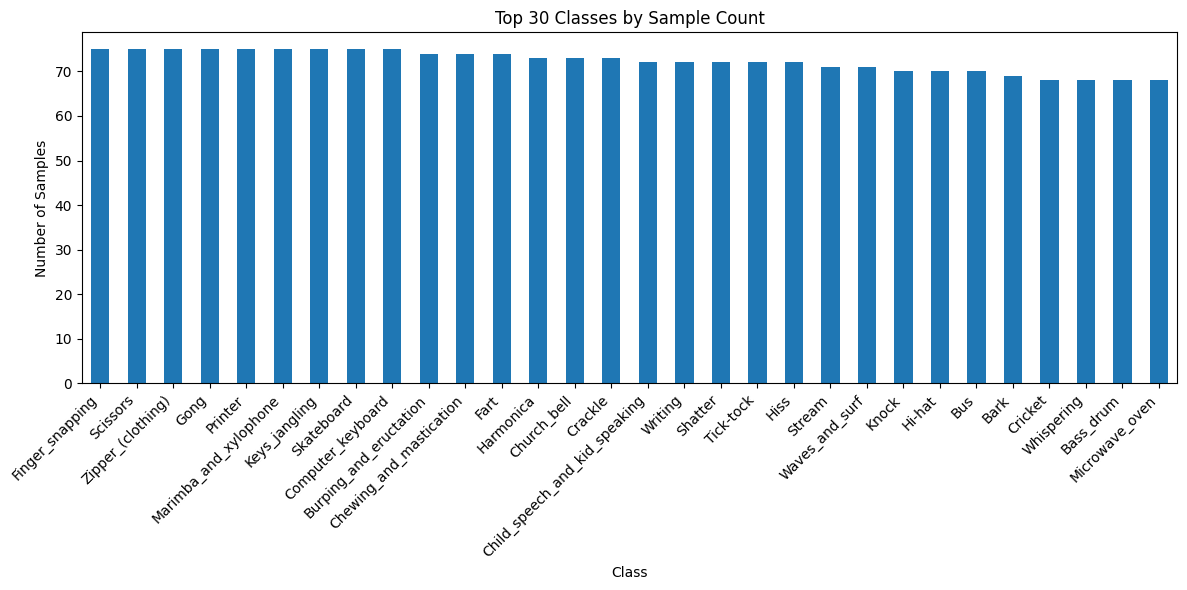

In [43]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
class_counts.head(30).plot(kind='bar')
plt.title('Top 30 Classes by Sample Count')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3. Prepare Data for Training

Split into:
- 10% test set (held out completely)
- 90% train+validation (will be further split by fastai)

In [44]:
# Prepare feature columns and target
feature_cols = [col for col in single_class_df.columns 
                if col not in ['file', 'fname', 'labels', 'num_labels']]

print(f"Number of feature columns: {len(feature_cols)}")
print(f"Feature columns: {feature_cols[:10]}...")  # Show first 10

X = single_class_df[feature_cols]
y = single_class_df['labels']

print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")

Number of feature columns: 2474
Feature columns: ['stft_mean_0', 'stft_mean_1', 'stft_mean_2', 'stft_mean_3', 'stft_mean_4', 'stft_mean_5', 'stft_mean_6', 'stft_mean_7', 'stft_mean_8', 'stft_mean_9']...

X shape: (4269, 2474)
y shape: (4269,)


In [45]:
# First split: 90% train+val, 10% test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

print(f"Train+Val size: {len(X_trainval)} ({100*len(X_trainval)/len(X):.1f}%)")
print(f"Test size: {len(X_test)} ({100*len(X_test)/len(X):.1f}%)")

Train+Val size: 3842 (90.0%)
Test size: 427 (10.0%)


In [46]:
# Create dataframe for fastai (train+val only)
trainval_df = pd.DataFrame(X_trainval, columns=feature_cols)
trainval_df['label'] = y_trainval.values
trainval_df = trainval_df.reset_index(drop=True)

print(f"Train+Val dataframe shape: {trainval_df.shape}")
print(f"\nFirst few rows:")
trainval_df.head()

Train+Val dataframe shape: (3842, 2475)

First few rows:


,stft_mean_0,stft_mean_1,stft_mean_2,stft_mean_3,stft_mean_4,stft_mean_5,stft_mean_6,stft_mean_7,stft_mean_8,stft_mean_9,...,cqt_std_75,cqt_std_76,cqt_std_77,cqt_std_78,cqt_std_79,cqt_std_80,cqt_std_81,cqt_std_82,cqt_std_83,label
0,0.192467,0.233631,0.297123,0.338336,0.360872,0.376400,0.338145,0.293152,0.293888,0.331492,...,0.114155,0.118343,0.122612,0.120143,0.117682,0.114477,0.113995,0.112645,0.101827,Run
1,0.415867,0.444465,0.433877,0.432379,0.437390,0.439932,0.438554,0.438155,0.431645,0.444157,...,0.122906,0.126272,0.131689,0.137714,0.138380,0.137418,0.137910,0.136623,0.134667,Chewing_and_mastication
2,0.054193,0.200226,0.365156,0.474023,0.529659,0.569585,0.597100,0.606081,0.609480,0.604805,...,0.136962,0.133530,0.137209,0.137903,0.140420,0.136840,0.137478,0.135000,0.129730,Hiss
3,0.782135,0.764415,0.607320,0.487561,0.371893,0.315002,0.305910,0.291965,0.291009,0.327514,...,0.110431,0.128692,0.095962,0.044049,0.046127,0.052454,0.071005,0.057240,0.039210,Gong
4,0.762978,0.808411,0.783182,0.685008,0.579764,0.507016,0.491780,0.490267,0.470167,0.452825,...,0.106676,0.106954,0.103506,0.105257,0.113481,0.115431,0.108414,0.106125,0.104540,Tick-tock


In [47]:
# Check for missing values
print(f"Shape before filtering missing values: {trainval_df.shape}")
missing_cols = trainval_df.isnull().sum()
missing_cols_with_nulls = missing_cols[missing_cols > 0]

if len(missing_cols_with_nulls) > 0:
    print(f"\nColumns with missing values: {len(missing_cols_with_nulls)}")
    print(f"Rows with any missing values: {trainval_df.isnull().any(axis=1).sum()}")
    print(f"\nSample of columns with missing values:")
    print(missing_cols_with_nulls.head(10))

    # Filter out rows with any missing values
    trainval_df = trainval_df.dropna()
    # IMPORTANT: Reset index after dropping rows to avoid index mismatch errors later
    trainval_df = trainval_df.reset_index(drop=True)
    
    print(f"\nShape after filtering missing values: {trainval_df.shape}")
    print(f"Rows removed: {len(X_trainval) - len(trainval_df)}")
else:
    print("No missing values found!")

Shape before filtering missing values: (3842, 2475)

Columns with missing values: 2474
Rows with any missing values: 1

Sample of columns with missing values:
stft_mean_0    1
stft_mean_1    1
stft_mean_2    1
stft_mean_3    1
stft_mean_4    1
stft_mean_5    1
stft_mean_6    1
stft_mean_7    1
stft_mean_8    1
stft_mean_9    1
dtype: int64

Shape after filtering missing values: (3841, 2475)
Rows removed: 1


## 4. Train Random Forest with FastAI

FastAI provides excellent tabular learner capabilities with built-in support for Random Forests.

### FastAI Tabular Learning Workflow:
1. Define categorical and continuous variables
2. Create preprocessing pipeline (Normalize, Categorify, FillMissing)
3. Create TabularDataLoaders
4. Train using tabular_learner

In [48]:
# Define variables
cat_names = []  # No categorical variables in our features
cont_names = feature_cols  # All features are continuous
dep_var = 'label'  # Target variable

print(f"Categorical variables: {len(cat_names)}")
print(f"Continuous variables: {len(cont_names)}")
print(f"Dependent variable: {dep_var}")

Categorical variables: 0
Continuous variables: 2474
Dependent variable: label


In [49]:
# Create preprocessing pipeline
procs = [Categorify, FillMissing, Normalize]

# Create TabularDataLoaders with 20% validation split
dls = TabularDataLoaders.from_df(
    trainval_df,
    path='.',
    procs=procs,
    cat_names=cat_names,
    cont_names=cont_names,
    y_names=dep_var,
    valid_idx=list(range(int(0.8*len(trainval_df)), len(trainval_df))),  # Last 20% for validation
    bs=64
)

print(f"Training batches: {len(dls.train)}")
print(f"Validation batches: {len(dls.valid)}")
print(f"\nClasses: {dls.vocab}")
print(f"Number of classes: {len(dls.vocab)}")

Training batches: 48
Validation batches: 13

Classes: ['Accelerating_and_revving_and_vroom', 'Accordion', 'Acoustic_guitar', 'Bark', 'Bass_drum', 'Bass_guitar', 'Bathtub_(filling_or_washing)', 'Bicycle_bell', 'Burping_and_eructation', 'Bus', 'Buzz', 'Car_passing_by', 'Chewing_and_mastication', 'Child_speech_and_kid_speaking', 'Chink_and_clink', 'Chirp_and_tweet', 'Church_bell', 'Clapping', 'Computer_keyboard', 'Crackle', 'Cricket', 'Crowd', 'Cupboard_open_or_close', 'Cutlery_and_silverware', 'Drawer_open_or_close', 'Drip', 'Electric_guitar', 'Fart', 'Female_singing', 'Female_speech_and_woman_speaking', 'Fill_(with_liquid)', 'Finger_snapping', 'Frying_(food)', 'Gasp', 'Glockenspiel', 'Gong', 'Gurgling', 'Harmonica', 'Hi-hat', 'Hiss', 'Keys_jangling', 'Knock', 'Male_singing', 'Male_speech_and_man_speaking', 'Marimba_and_xylophone', 'Mechanical_fan', 'Meow', 'Microwave_oven', 'Motorcycle', 'Printer', 'Purr', 'Race_car_and_auto_racing', 'Raindrop', 'Run', 'Scissors', 'Screaming', 'Shatter'

In [50]:
# Show a batch
dls.show_batch(max_n=5)

### Train Random Forest Baseline

We'll use sklearn's RandomForestClassifier since fastai's tabular_learner is primarily for neural networks.
However, we'll use fastai's preprocessing and data handling capabilities.

In [51]:
# Extract train and validation data from fastai DataLoaders
# Get indices
train_idx = dls.train.dataset.items.index
valid_idx = dls.valid.dataset.items.index

# Prepare training data
X_train = trainval_df.iloc[train_idx][feature_cols]
y_train = trainval_df.iloc[train_idx]['label']

X_val = trainval_df.iloc[valid_idx][feature_cols]
y_val = trainval_df.iloc[valid_idx]['label']

print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples (held out)")

Training set: 3072 samples
Validation set: 769 samples
Test set: 427 samples (held out)


In [52]:
# Train Random Forest Classifier
print("Training Random Forest Classifier...")
print("This may take a few minutes...\n")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_model.fit(X_train, y_train)
print("\nTraining complete!")

Training Random Forest Classifier...
This may take a few minutes...



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.5s



Training complete!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.8s finished


## 5. Evaluate on Validation Set

In [53]:
# Validation predictions
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Accuracy %: {100 * val_accuracy:.2f}%")

Validation Accuracy: 0.4226
Validation Accuracy %: 42.26%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [54]:
# Detailed classification report (for validation)
print("\nValidation Classification Report:")
print("=" * 80)
print(classification_report(y_val, y_val_pred, zero_division=0))


Validation Classification Report:
                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.00      0.00      0.00         5
                         Accordion       0.78      0.70      0.74        10
                   Acoustic_guitar       0.00      0.00      0.00         1
                              Bark       0.44      0.67      0.53        12
                         Bass_drum       0.77      0.62      0.69        16
                       Bass_guitar       0.75      1.00      0.86        15
      Bathtub_(filling_or_washing)       0.00      0.00      0.00        10
                      Bicycle_bell       0.69      0.90      0.78        10
            Burping_and_eructation       0.48      0.67      0.56        15
                               Bus       0.47      0.58      0.52        12
                              Buzz       0.50      0.17      0.25        12
                    Car_passing_by       0.31      0

In [55]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance.head(20))


Top 20 Most Important Features:
          feature  importance
2388  cqt_mean_82    0.002097
2054   mel_mean_4    0.001789
2438   cqt_std_48    0.001687
2367  cqt_mean_61    0.001612
4     stft_mean_4    0.001609
1031   stft_std_6    0.001564
3     stft_mean_3    0.001544
1030   stft_std_5    0.001514
2317  cqt_mean_11    0.001510
5     stft_mean_5    0.001499
1034   stft_std_9    0.001474
2400   cqt_std_10    0.001473
2053   mel_mean_3    0.001456
1028   stft_std_3    0.001449
2387  cqt_mean_81    0.001448
1032   stft_std_7    0.001414
2323  cqt_mean_17    0.001409
2056   mel_mean_6    0.001405
8     stft_mean_8    0.001400
2320  cqt_mean_14    0.001388


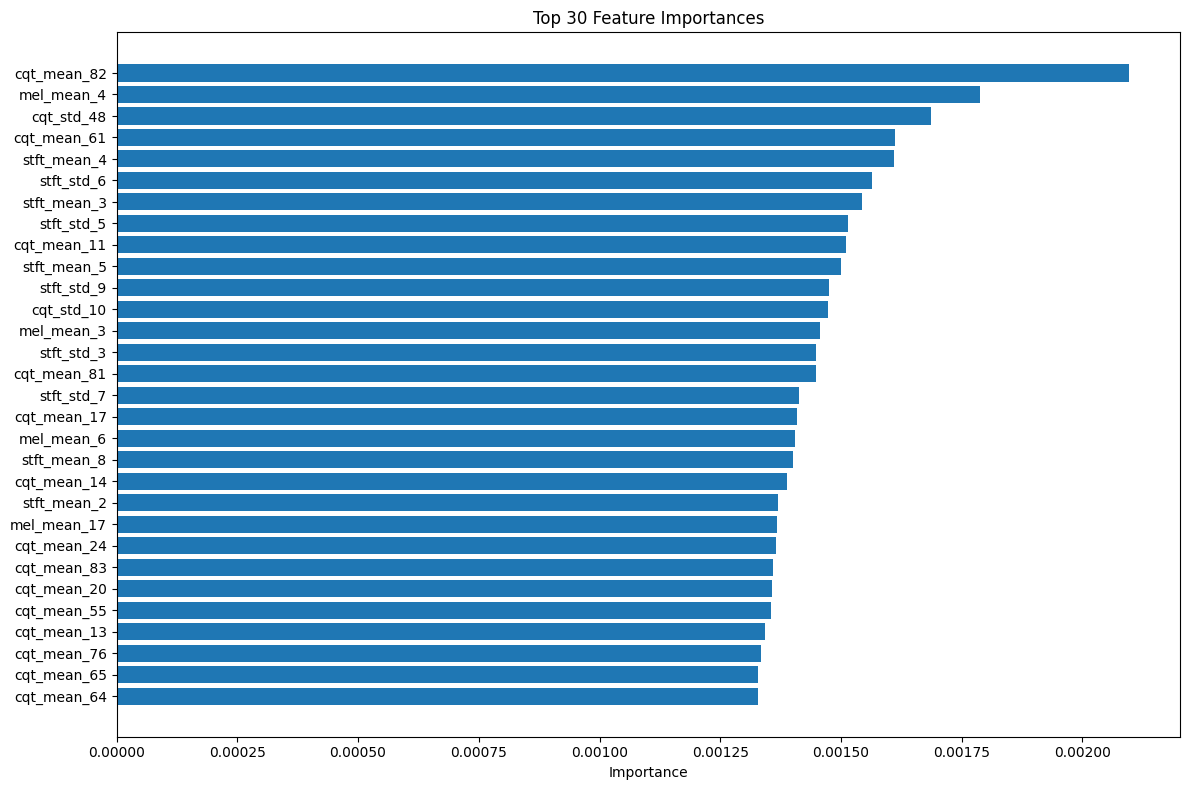

In [56]:
# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 30 Feature Importances')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Final Evaluation on Test Set

Now we evaluate on the held-out 10% test set.

In [57]:
# Test predictions
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("=" * 80)
print("FINAL TEST SET RESULTS")
print("=" * 80)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Accuracy %: {100 * test_accuracy:.2f}%")
print("=" * 80)

FINAL TEST SET RESULTS
Test Accuracy: 0.4567
Test Accuracy %: 45.67%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.1s finished


In [58]:
# Detailed classification report (for test)
print("\nTest Classification Report:")
print("=" * 80)
print(classification_report(y_test, y_test_pred, zero_division=0))


Test Classification Report:
                                    precision    recall  f1-score   support

Accelerating_and_revving_and_vroom       0.00      0.00      0.00         3
                         Accordion       1.00      0.60      0.75         5
                              Bark       0.67      0.57      0.62         7
                         Bass_drum       0.71      0.71      0.71         7
                       Bass_guitar       0.50      0.83      0.62         6
      Bathtub_(filling_or_washing)       0.50      0.17      0.25         6
                      Bicycle_bell       0.71      0.71      0.71         7
            Burping_and_eructation       0.71      0.71      0.71         7
                               Bus       0.36      0.57      0.44         7
                              Buzz       0.50      0.20      0.29         5
                    Car_passing_by       0.25      0.50      0.33         6
           Chewing_and_mastication       0.21      0.43   

In [59]:
# Per-class accuracy
test_results = pd.DataFrame({
    'true_label': y_test,
    'predicted_label': y_test_pred
})

# Calculate per-class accuracy
class_accuracy = {}
for label in test_results['true_label'].unique():
    mask = test_results['true_label'] == label
    correct = (test_results[mask]['true_label'] == test_results[mask]['predicted_label']).sum()
    total = mask.sum()
    class_accuracy[label] = correct / total if total > 0 else 0

class_acc_df = pd.DataFrame({
    'class': list(class_accuracy.keys()),
    'accuracy': list(class_accuracy.values()),
    'samples': [sum(test_results['true_label'] == c) for c in class_accuracy.keys()]
}).sort_values('accuracy', ascending=False)

print("\nPer-Class Test Accuracy (Top 20):")
print(class_acc_df.head(20))


Per-Class Test Accuracy (Top 20):
                            class  accuracy  samples
35                           Fart  1.000000        7
4   Child_speech_and_kid_speaking  1.000000        7
21                          Knock  1.000000        7
56                      Harmonica  1.000000        7
11                   Glockenspiel  1.000000        6
37                    Bass_guitar  0.833333        6
23                Electric_guitar  0.800000        5
42                 Mechanical_fan  0.800000        5
8                 Finger_snapping  0.750000        8
17                 Female_singing  0.714286        7
39                 Waves_and_surf  0.714286        7
22                   Bicycle_bell  0.714286        7
41           Drawer_open_or_close  0.714286        7
14         Burping_and_eructation  0.714286        7
45                      Bass_drum  0.714286        7
62                         Hi-hat  0.714286        7
54                     Motorcycle  0.666667        6
7          

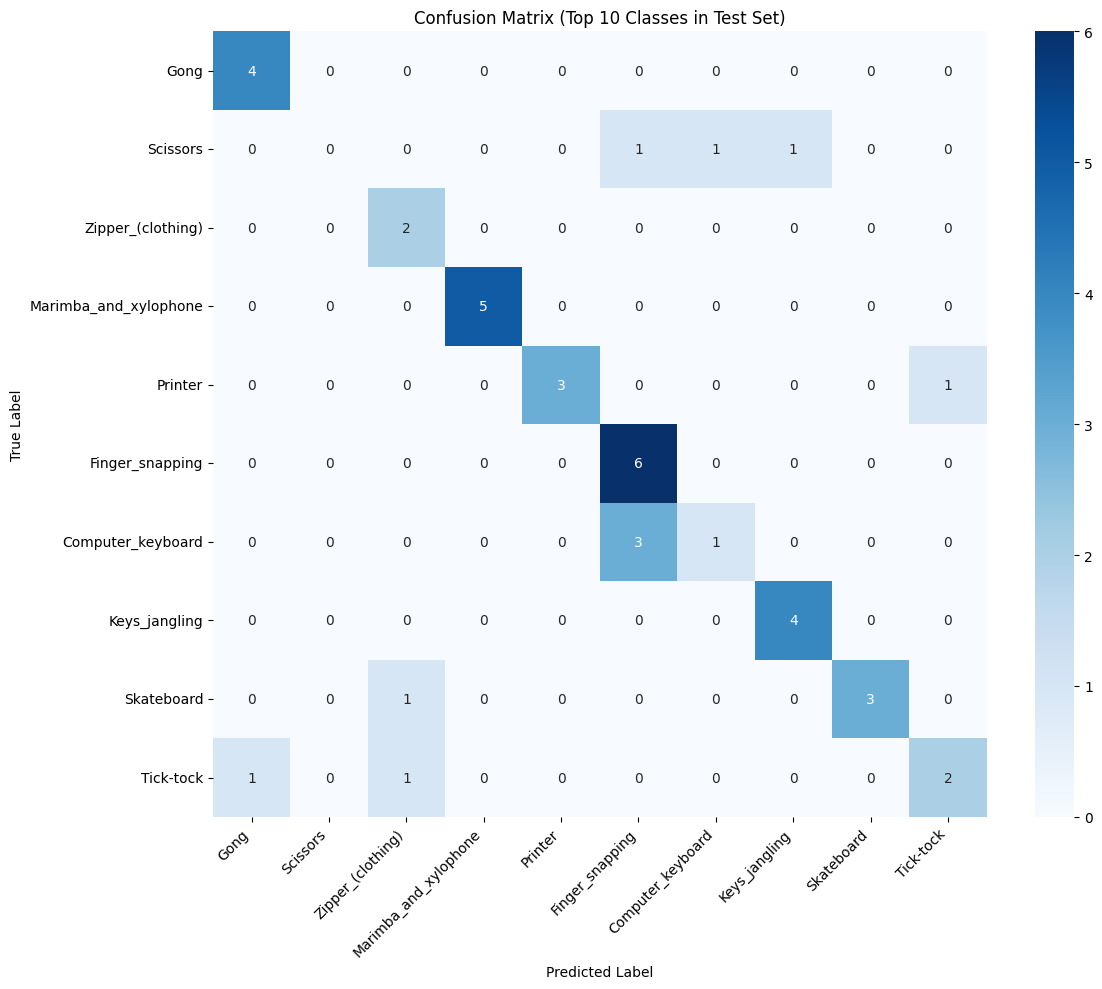

In [60]:
# Confusion matrix for most common classes
top_classes = y_test.value_counts().head(10).index.tolist()
test_subset_mask = y_test.isin(top_classes)

if test_subset_mask.sum() > 0:
    # Convert y_test_pred to Series with same index as y_test to avoid alignment issues
    y_test_pred_series = pd.Series(y_test_pred, index=y_test.index)
    
    cm = confusion_matrix(y_test[test_subset_mask], 
                         y_test_pred_series[test_subset_mask], 
                         labels=top_classes)
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=top_classes, yticklabels=top_classes)
    plt.title('Confusion Matrix (Top 10 Classes in Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## 7. Summary and Model Insights

In [61]:
print("\n" + "=" * 80)
print("MODEL SUMMARY")
print("=" * 80)
print(f"Model: Random Forest Classifier")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")
print(f"\nDataset:")
print(f"  Total single-class samples: {len(single_class_df)}")
print(f"  Number of classes: {len(y.unique())}")
print(f"  Number of features: {len(feature_cols)}")
print(f"\nSplit:")
print(f"  Training: {len(X_train)} samples ({100*len(X_train)/len(single_class_df):.1f}%)")
print(f"  Validation: {len(X_val)} samples ({100*len(X_val)/len(single_class_df):.1f}%)")
print(f"  Test: {len(X_test)} samples ({100*len(X_test)/len(single_class_df):.1f}%)")
print(f"\nResults:")
print(f"  Validation Accuracy: {100 * val_accuracy:.2f}%")
print(f"  Test Accuracy: {100 * test_accuracy:.2f}%")
print("=" * 80)


MODEL SUMMARY
Model: Random Forest Classifier
Number of trees: 100
Max depth: 20

Dataset:
  Total single-class samples: 4269
  Number of classes: 74
  Number of features: 2474

Split:
  Training: 3072 samples (72.0%)
  Validation: 769 samples (18.0%)
  Test: 427 samples (10.0%)

Results:
  Validation Accuracy: 42.26%
  Test Accuracy: 45.67%


## 8. Save Model (Optional)

In [62]:
# Uncomment to save the model
# import joblib
# joblib.dump(rf_model, 'random_forest_model.pkl')
# print("Model saved to 'random_forest_model.pkl'")